## EEML2019: ConvNets and Computer Vision Tutorial (PART II)

### Knowledge distillation: Distilling a pre-trained teacher model into a smaller student model 

* Define student model (custom Resnet-21)
* Load pre-trained teacher model (Resnet-50) 
* Add KL distillation loss between teacher and student
* Observe the impact of temperature in softmax for teacher predictions
* Train student with the joint loss



###  The total loss for the student is:
\begin{equation}
\mathcal{L} = \mathcal{L}_{\text{classif}} + \lambda \mathcal{L}_{\text{distill}}
\end{equation}

For classification loss we use the regular cross-entropy and for the distillation loss, we use Kullback-Leibler (KL) divergence. $\lambda$ is a normalisation factor explained below.


**Reminder**:

Given two distributions $t$ and $s$, we define their cross-entropy over a given set as:

$$H(t,s) = H(t) + \text{KL}(t,s),$$

where $H(t)$ is the entropy of $t$, i.e. $H(t) = \sum_{i=1}^{N}t(x_i) \cdot \log t(x_i)$

and $\text{KL}(t,s)$ is the KL divergence between $t$ and $s$, i.e. $\text{KL}(t,s) = \sum_{i=1}^{N}t(x_i) \cdot \log \frac{t(x_i)}{s(x_i)} . $

However, in most cases of interest to us, $t$ is a constant (either ground truth labels or teacher predictions also considered as constant), so the entropy term can be ignored since its gradient is 0. 

Hence we can use cross-entropy $H(t,s)$ for both losses: 
- the mismatch between ground truth and student predictions. 
- the mismatch between teacher and student distributions.

In the context of distillation, it is useful to also remember that the outputs of the network are logits, which we interpret as probabilities when passed through softmax:

$$p_i^{(T)} =\frac{\exp{(\text{logits}_i / T) }}{\sum_j \exp{(\text{logits}_j / T) }}. $$

$T$ is the softmax temperature usually set to 1. Setting it to a higher value smooths the output probability distribution, an effect desired in distillation. More precisely, we will use

\begin{equation}
\mathcal{L}_{\text{distill}} = H(\text{p}_{\text{teacher}}^{(T)}, \text{p}_{\text{student}}^{(T)}),
\end{equation}

**The normalisation factor** 

$\lambda$ is a normalisation factor that ensures the gradients of the two loss terms are comparable in scale. Note that the gradients of the distill loss term scale as $\frac{1}{T^2}$ due to the logits being divided by $T$.  Hence we use $$\lambda = T^2$$ to bring distillation term gradients to the same scale as the classification term gradients.





In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import time

import tensorflow as tf

# Don't forget to select GPU runtime environment in Runtime -> Change runtime type
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
import pylab as pl
from IPython import display

import collections
import enum

Found GPU at: /device:GPU:0


In [0]:
# Reset graph
tf.reset_default_graph()

### Copy the pretrained weights of teacher model on the virtual machine
- we won't do this today as the checkpoint has about 250M

In [0]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

## Download dataset to be used for training and testing
* Cifar-10 equivalent of MNIST for natural RGB images

* 60000 32x32 colour images in 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

* train: 50000; test: 10000

In [0]:
cifar10 = tf.keras.datasets.cifar10
# (down)load dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Check sizes of tensors
print ('Size of training images')
print (train_images.shape)
print ('Size of training labels')
print (train_labels.shape)
print ('Size of test images')
print (test_images.shape)
print ('Size of test labels')
print (test_labels.shape)

assert train_images.shape[0] == train_labels.shape[0]

## Display the images
The gallery function below shows sample images from the data, together with their labels.

In [0]:
MAX_IMAGES = 10
def gallery(images, label, title='Input images'):  
  class_dict = [u'airplane', u'automobile', u'bird', u'cat', u'deer', u'dog', u'frog', u'horse', u'ship', u'truck']
  num_frames, h, w, num_channels = images.shape
  num_frames = min(num_frames, MAX_IMAGES)
  ff, axes = plt.subplots(1, num_frames,
                          figsize=(num_frames, 1),
                          subplot_kw={'xticks': [], 'yticks': []})
  for i in range(0, num_frames):
    if num_channels == 3:
      axes[i].imshow(np.squeeze(images[i]))
    else:
      axes[i].imshow(np.squeeze(images[i]), cmap='gray')
    axes[i].set_title(class_dict[label[i][0]])
    plt.setp(axes[i].get_xticklabels(), visible=False)
    plt.setp(axes[i].get_yticklabels(), visible=False)
  ff.subplots_adjust(wspace=0.1)
  plt.show()

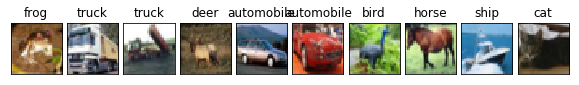

In [0]:
gallery(train_images, train_labels)

## Prepare the data for training and testing
* for training, we use stochastic optimizers (e.g. SGD, Adam), so we need to sample at random mini-batches from the training dataset
* for testing, we iterate sequentially through the test set

In [0]:
# define dimension of the batches to sample from the datasets
BATCH_SIZE_TRAIN = 100 #@param
BATCH_SIZE_TEST = 100 #@param

# create Dataset objects using the data previously downloaded
dataset_train = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
# we shuffle the data and sample repeatedly batches for training
batched_dataset_train = dataset_train.shuffle(100000).repeat().batch(BATCH_SIZE_TRAIN)
# create iterator to retrieve batches
iterator_train = batched_dataset_train.make_one_shot_iterator()
# get a training batch of images and labels
(batch_train_images, batch_train_labels) = iterator_train.get_next()

# check that the shape of the training batches is the expected one
print ('Shape of training images')
print (batch_train_images)
print ('Shape of training labels')
print (batch_train_labels)

In [0]:
# we do the same for test dataset
dataset_test = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
batched_dataset_test = dataset_test.repeat().batch(BATCH_SIZE_TEST)
iterator_test = batched_dataset_test.make_one_shot_iterator() 
(batch_test_images, batch_test_labels) = iterator_test.get_next()
print ('Shape of test images')
print (batch_test_images)
print ('Shape of test labels')
print (batch_test_labels)

In [0]:
# Squeeze labels and convert from uint8 to int32 - required below by the loss op
batch_test_labels = tf.cast(tf.squeeze(batch_test_labels), tf.int32)
batch_train_labels = tf.cast(tf.squeeze(batch_train_labels), tf.int32)

## Preprocess input for training and testing

In [0]:
# Data augmentation
# - scale image to [-1 , 1]
# - during training: apply horizontal flip randomly
# - random crop after padding

def train_image_preprocess(h, w, num_transf=None):
  def fn(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = image * 2 - 1
    # image = tf.reshape(image, (32, 32, 3))
    image = tf.image.random_flip_left_right(image)
    # Data augmentation: pad images and randomly sample a (h, w) patch.
    image = tf.pad(image, [[0, 0], [4, 4], [4, 4], [0, 0]], mode='CONSTANT')
    image = tf.random_crop(image, size=(BATCH_SIZE_TRAIN, h, w, 3))
    return image
  return fn

def test_image_preprocess():
  def fn(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = image * 2 - 1
    # image = tf.reshape(image, (32, 32, 3))
    return image
  return fn


## Define the models

In [0]:
# define parameters of resnet blocks for two resnet models
ResNetBlockParams = collections.namedtuple(
    "ResNetBlockParams", ["output_channels", "bottleneck_channels", "stride"])

# teacher
BLOCKS_50 = (
    (ResNetBlockParams(256, 64, 1),) * 2 + (ResNetBlockParams(256, 64, 2),),
    (ResNetBlockParams(512, 128, 1),) * 3 + (ResNetBlockParams(512, 128, 2),),
    (ResNetBlockParams(1024, 256, 1),) * 5 + (ResNetBlockParams(1024, 256, 2),),
    (ResNetBlockParams(2048, 512, 1),) * 3)

# student
BLOCKS_21 = (
    (ResNetBlockParams(256, 64, 1),) + (ResNetBlockParams(256, 64, 2),),
    (ResNetBlockParams(512, 128, 1),) + (ResNetBlockParams(512, 128, 2),),
    (ResNetBlockParams(1024, 256, 1),) + (ResNetBlockParams(1024, 256, 2),),
    (ResNetBlockParams(2048, 512, 1),))

In [0]:
#@title Utils
# initializer 
he_initializer = tf.contrib.layers.variance_scaling_initializer()
# helper functions
def _fixed_padding(inputs, kernel_size):
  """Pads the input along the spatial dimensions."""
  pad_total = kernel_size - 1
  pad_begin = pad_total // 2
  pad_end = pad_total - pad_begin
  padded_inputs = tf.pad(inputs, [[0, 0], [pad_begin, pad_end],
                                  [pad_begin, pad_end], [0, 0]])
  return padded_inputs

def _max_pool2d_same(inputs, kernel_size, stride, padding):
  """Strided 2-D max-pooling with fixed padding. 
  When padding='SAME' and stride > 1, we do fixed zero-padding followed by 
  max_pool2d with 'VALID' padding."""

  if padding == "SAME" and stride > 1:
    padding = "VALID"
    inputs = _fixed_padding(inputs, kernel_size)
  return tf.layers.MaxPooling2D(kernel_size, strides=stride, padding=padding)(inputs)

def _conv2d_same(inputs, num_outputs, kernel_size, stride, use_bias=False,
                 name="conv_2d_same"):
  """Strided 2-D convolution with 'SAME' padding. If stride > 1, we do fixed
  zero-padding, followed by conv2d with 'VALID' padding."""
  if stride == 1:
    padding = "SAME"
  else:
    padding = "VALID"
    inputs = _fixed_padding(inputs, kernel_size)

  return tf.layers.Conv2D(num_outputs, kernel_size, strides=stride,
                          padding=padding, use_bias=use_bias, name=name,
                          kernel_initializer=he_initializer)(inputs)

In [0]:
# define resnet block v2
def resnet_block(inputs, output_channels, bottleneck_channels, stride,
                 training=None, name="resnet_block"):
  """Create a resnet block."""
  num_input_channels = inputs.get_shape()[-1]
  batch_norm_args = {
      "training": training
      }
  # ResNet V2 uses pre-activation, where the batch norm and relu are before
  # convolutions, rather than after as in ResNet V1.
  preact = tf.layers.BatchNormalization(name=name+"/bn_preact")(inputs,
                                                                **batch_norm_args)
  preact = tf.nn.relu(preact)

  if output_channels == num_input_channels:
    # Use subsampling to match output size.
    # Note we always use `inputs` in this case, not `preact`.
    if stride == 1:
      shortcut = inputs
    else:
      shortcut = _max_pool2d_same(inputs, 1, stride=stride, padding="SAME")
  else:
    # Use 1x1 convolution shortcut to increase channels to `output_channels`.
    shortcut = tf.layers.Conv2D(output_channels, 1, stride,
                                use_bias=False,
                                name=name+"/conv_shortcut")(preact)
  ###########################
  # YOUR CODE HERE copy the code you implemented in Part 1
  
  output = shortcut + residual

  return output

In [0]:
# stack resnet blocks
def _build_resnet_blocks(inputs, blocks, batch_norm_args):
  """Connects the resnet block into the graph."""
  outputs = []

  for num, subblocks in enumerate(blocks):
    with tf.variable_scope("block_{}".format(num)):
      for i, block in enumerate(subblocks):
        args = {
            "name": "resnet_block_{}".format(i)
        }
        args.update(block._asdict())
        args.update(batch_norm_args)
        inputs = resnet_block(inputs, **args)
        outputs += [inputs]

  return outputs

In [0]:
# define full architecture: input convs, resnet blocks, output classifier
def resnet_v2(inputs, blocks, is_training=True,
              num_classes=1000,
              use_global_pool=True, name="resnet_v2"):
  """ResNet V2."""
  blocks = tuple(blocks)

  batch_norm_args = {
      "training": is_training
  }

  outputs = []
  with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    # Add initial non-resnet conv layer and max_pool
    inputs = _conv2d_same(inputs, 64, 7, stride=2, name="root")
    inputs = _max_pool2d_same(inputs, 3, stride=2, padding="SAME")
    outputs += [inputs]

    # Stack resnet blocks
    resnet_outputs = _build_resnet_blocks(inputs, blocks, batch_norm_args)

    outputs += resnet_outputs

    # Take the activations of the last resnet block.
    inputs = resnet_outputs[-1]

    inputs = tf.layers.BatchNormalization(name="bn_postnorm")(inputs,
                                                              **batch_norm_args)
    inputs = tf.nn.relu(inputs)
    outputs += [inputs]

    if use_global_pool:
      inputs = tf.reduce_mean(inputs, [1, 2], name="use_global_pool",
                              keepdims=True)
      outputs += [inputs]

    # Add output classifier
    inputs = tf.layers.Conv2D(num_classes, 1, name="logits")(inputs)
    inputs = tf.squeeze(inputs, axis=[1, 2])
    outputs += [inputs]

  return outputs[-1]

## Set up training pipeline

In [0]:
# First define the preprocessing ops for the train/test data
crop_height = 32 #@param 
crop_width = 32 #@param 
preprocess_fn_train = train_image_preprocess(crop_height, crop_width)
preprocess_fn_test = test_image_preprocess()
NUM_CLASSES = 10 #@param

### Instantiate teacher

In [0]:
teacher_blocks = BLOCKS_50
# teacher runs in inference mode
with tf.variable_scope("teacher"):
  teacher_predictions = resnet_v2(preprocess_fn_train(batch_train_images),
                                  teacher_blocks,
                                  num_classes=NUM_CLASSES, is_training=False)


### We do not want to alter the teacher weights, so apply `tf.stop_gradients` to `teacher_predictions`

In [0]:
################
# YOUR CODE HERE teacher_predictions = tf.stop_gradient...

### Load pre-trained weights
- we won't do this today since the checkpoint was not uploaded 

In [0]:
# # Create saver to restore the pre-trained model  
# saver = tf.train.Saver(var_map, reshape=True)

### Instantiate student and get predictions

In [0]:
student_blocks = BLOCKS_21
with tf.variable_scope("student"):
  student_train_predictions = resnet_v2(preprocess_fn_train(batch_train_images),
                                        student_blocks,
                                        num_classes=NUM_CLASSES,
                                        is_training=True)
  print (student_train_predictions)

  student_test_predictions = resnet_v2(preprocess_fn_test(batch_test_images),
                                       student_blocks,
                                       num_classes=NUM_CLASSES,
                                       is_training=False)
  print (student_test_predictions)

In [0]:
# Get number of parameters in a scope by iterating through the trainable variables
def get_num_params(scope):
  total_parameters = 0
  for variable in tf.trainable_variables(scope):
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
      variable_parameters *= dim.value
    total_parameters += variable_parameters
  return total_parameters

In [0]:
# Get number of parameters in the models.
print ("Total number of parameters of teacher model")
print (get_num_params("teacher"))
print ("Total number of parameters of student model")
print (get_num_params("student"))

Total number of parameters of teacher model
23520842
Total number of parameters of student model
9496394


### Set up the training for student, adding the distillation loss weighted by the square of temperature as explained above. 

Normally we use T = 1, but for distillation we use T>1, e.g. T=5. We will visualise later the impact of T on logits.

In [0]:
T_distill = 5.0   
T_normal = 1.0

#### First define the regular cross-entropy classification loss

In [0]:
def classification_loss(logits=None, labels=None):
  # We reduce over batch dimension, to ensure the loss is a scalar.   
  return tf.reduce_mean(
      tf.nn.sparse_softmax_cross_entropy_with_logits(
          labels=labels, logits=logits))

#### Define the distillation loss

You can do this either with

* `tf.distributions.kl_divergence` between the teacher and student distributions, respectively; or 
* `softmax_cross_entropy_with_logits`. Remember that in this case the labels are expected to sum to 1, while the output of the teacher network is logits. So we need to apply `softmax` on the `teacher_predictions`.


In [0]:
# Using tf.distributions.kl_divergence
# pp = tf.distributions.Categorical(logits=teacher_predictions)
# qq = tf.distributions.Categorical(logits=student_train_predictions)

# distill_kl_loss = tf.reduce_mean(tf.distributions.kl_divergence(pp, qq))



In [0]:
# OR simpler, using cross entropy
################
# YOUR CODE HERE distill_kl_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(...

#### Define the joint training loss

In [0]:
################
# YOUR CODE HERE lambda_ = ...
# YOUR CODE HERE train_loss = classification_loss...
# YOUR CODE HERE add the weighted distillation term

In [0]:
# For evaluation, we look at top_k_accuracy since it's easier to interpret; normally k=1 or k=5
def top_k_accuracy(k, labels, logits):
  in_top_k = tf.nn.in_top_k(predictions=tf.squeeze(logits), targets=labels, k=k)
  return tf.reduce_mean(tf.cast(in_top_k, tf.float32))

In [0]:
#@title Set up the training; better to start with lower lr and longer training schedule
def get_optimizer(step):
  """Get the optimizer used for training."""
  lr_schedule = (80e3, 100e3, 110e3)
  lr_schedule = tf.to_int64(lr_schedule)
  lr_factor = 0.1
  
  lr_init = 0.01
  num_epochs = tf.reduce_sum(tf.to_float(step >= lr_schedule))
  lr = lr_init * lr_factor**num_epochs

  return tf.train.MomentumOptimizer(learning_rate=lr, momentum=0.9)

# Create a global step that is incremented during training; useful for e.g. learning rate annealing
global_step = tf.train.get_or_create_global_step()

# instantiate the optimizer
optimizer = get_optimizer(global_step)

# Get training ops, including BatchNorm update ops
training_op = optimizer.minimize(train_loss, global_step)
update_ops = tf.group(*tf.get_collection(tf.GraphKeys.UPDATE_OPS))
training_op = tf.group(training_op, update_ops)

# Display loss function
def plot_losses(loss_list, steps):
  display.clear_output(wait=True)
  display.display(pl.gcf())
  pl.plot(steps, loss_list, c='b')
  time.sleep(1.0)

### Teacher and student accuracy

In [0]:
test_acc = top_k_accuracy(1, batch_test_labels, student_test_predictions)

# We compute the accuracy of the teacher on the train set to make sure that
# the loading of the pre-trained weights was successful; this should be above 90%;
# today it is close to random since the teacher doesn't use pretrained weights
acc_teacher = top_k_accuracy(1, batch_train_labels, teacher_predictions) 

### Define ops to visualise the impact of softmax temperature on output distributions

In [0]:
probs_high_temp = tf.nn.softmax(tf.div(teacher_predictions, T_distill)) 
probs_low_temp = tf.nn.softmax(tf.div(teacher_predictions, T_normal))

### Define training parameters

In [0]:
# Define number of training iterations and reporting intervals
TRAIN_ITERS = 90e3 #@param
REPORT_TRAIN_EVERY = 100 #@param
PLOT_EVERY = 500 #@param
REPORT_TEST_EVERY = 1000 #@param
TEST_ITERS = 100 #@param

### Create the session and initialise variables

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### Load pre-trained weights for teacher, and check accuracy to make sure the import was successful

In [0]:
# saver.restore(sess, "resnet50.ckpt")

num_batches = 100  # 100 batches * 64 samples per batch = 6400 out of 50000
avg_accuracy = 0.0
for _ in range(num_batches):
  accuracy = sess.run(acc_teacher)
  avg_accuracy += accuracy
avg_accuracy /= num_batches

# expected_accuracy > 90% if we had loaded a pretrained checkpoint
print ("Teacher accuracy on a subset of the train set {:.3f}%".format(avg_accuracy))

### Visualize the impact of temperature on the logits

In [0]:
probs_ht, probs_lt, gt = sess.run([probs_high_temp, probs_low_temp, tf.one_hot(batch_train_labels, NUM_CLASSES)])
# pick one sample and plot
idx = 10
plt.plot(probs_ht[idx], c='r', label='High Temp')
plt.plot(probs_lt[idx], c='g', label='Low Temp')
plt.plot(gt[idx], 'b--', label='GT')
plt.xlim([0,9])
plt.legend()
plt.show()

### Train the model.

If running out of memory, reduce the BATCH_SIZE_TRAIN, e.g. 32 or 16.

Note that the execution is slower and more memory is needed now, since for each training iteration of the student we need to run the forward pass for the teacher as well.

### Training the model

In [0]:
# Get test ops
test_acc_op = top_k_accuracy(1, batch_test_labels, student_test_predictions)
train_acc_op = top_k_accuracy(1, batch_train_labels, student_train_predictions)

In [0]:
train_iter = 0
losses = []
steps = []
for train_iter in range(int(TRAIN_ITERS)):
  _, train_loss_np = sess.run([training_op, train_loss])
  
  if (train_iter % REPORT_TRAIN_EVERY) == 0:
    losses.append(train_loss_np)
    steps.append(train_iter)
  if (train_iter % PLOT_EVERY) == 0:
    pass
    # plot_losses(losses, steps)    
    
  if (train_iter % REPORT_TEST_EVERY) == 0:
    avg_acc = 0.0
    train_avg_acc = 0.0
    for test_iter in range(TEST_ITERS):
      acc, acc_train = sess.run([test_acc_op, train_acc_op])
      avg_acc += acc
      train_avg_acc += acc_train
      
    avg_acc /= (TEST_ITERS)
    train_avg_acc /= (TEST_ITERS)
    print ('Test acc at iter {0:5d} out of {1:5d} is {2:.2f}%'.format(int(train_iter), int(TRAIN_ITERS), avg_acc*100.0))
    print ('Train acc at iter {0:5d} out of {1:5d} is {2:.2f}%'.format(int(train_iter), int(TRAIN_ITERS), train_avg_acc*100.0))